This code solves the Fokker-Planck forward problem described in the paper for predicting the probability density functions of daily discharge.

The code is applied in the "Obs-Guided" scenario and can be adjusted for the "7-Day Obs-Sim-Guided" scenario. The two methods described for UQ are employed here and we only consider the VALIDATION period for this analysis.

In [59]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [60]:
!pip install kaleido==0.2.1

In [61]:
import numpy as np
import matplotlib.pyplot as plt
import math
import random
import pandas as pd
from datetime import datetime, timedelta
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from scipy.stats import levy_stable
import os
from decimal import Decimal, getcontext
import matplotlib.dates as mdates
from scipy.interpolate import interp1d
from scipy.integrate import simpson
from scipy.integrate import simps

from google.colab import files
import kaleido

In [62]:
# Import data
data = pd.read_excel('/content/drive/MyDrive/Qdaily_1FG01_Yala_2014_2020.xlsx')

daily = data.iloc[:, [-4, -3, -2]]

# Validation period data
discharge = daily.iloc[1461:2191, 2].to_numpy()
prec = daily.iloc[1461:2191, 0].to_numpy()
pet = daily.iloc[1461:2191, 1].to_numpy()


#Compute the Effective precipitation
prec_eff = prec - pet
prec_eff[prec_eff < 0] = 0

#X(t)
def state_basin(MU, LANDA, q):
    n = len(q)
    X = np.zeros(n)
    X[0] = q[0]
    for i in range(1, n):
        if q[i] == 0:
            X[i] = X[i - 1] - (MU / LANDA) * X[i - 1]
        else:
            X[i] = X[i - 1] + (MU / LANDA) * q[i]
    return X

In [63]:
#parameters for the "Obs-Guided" scenario. These should be replaced in the case of "7-Day Obs-Sim-Guided" scenario
mu = 1.0220853264003489
lambd = 21.319795879190185
sigma = 0.17767390468174975

SIMULATION

In [64]:
# SDE drift and diffusion
def u(Q,X,q):
  return (- (mu/lambd) * Q**(2*mu-1) + (1/lambd) * X * q)

def v(Q):
  return (sigma*Q)**2

In [65]:
np.max(discharge)

199.519

In [66]:
Q = discharge
q = prec_eff
X = state_basin(mu, lambd, q)

Qc=Q[0]

#discretization of space and time
QM= 500
M=10000
h=(QM-0) / M

N= len(Q)
dt=1

Q_x=np.linspace(0, QM, M+1)
P=np.zeros((M+1, N))
f=np.zeros((M+1, N))
g=np.zeros((M+1, N))
A = np.zeros((M+1, M+1))
b = np.zeros(M+1)

#initial and boundary conditions
civ = 1/h
P[0,:]=0
P[M,:]=0
for ij in range(M+1):
  if Q_x[ij]>=Qc:
      P[ij+1,0]= civ
      break

S1 = dt / h
S2 = dt / (2*h**2)

In [67]:
# PP for only the predictions
PP = np.zeros((M+1, N))
PP[:, 0] = P[:, 0].copy()

In [68]:

for k in range(1, N):  # N because the last prediction is to be compared to  the last true discharge

  # initial conditions for allowing the inclusion of true  dischages
  # i.e, we consider the initial condition again after each day or 7-days as described in the paper.
  if k in range(0, N, 1):         # This becomes   if k in range(0, N, 7):, in the case of "7-Day Obs-Sim-Guided" scenario
      Qc=Q[k-1]
      P[:,k-1] = 0
      for ij in range(M+1):
        if Q_x[ij]>=Qc:
          P[ij+1,k-1]= civ           #This is where PP is important, as without that, it deletes the last simulation before this condition
          break

  for ii in range(M+1):
    f[ii,k-1] = u(Q_x[ii],X[k-1],q[k-1])
    g[ii,k-1] = v(Q_x[ii])


  for i in range(1,M):
    fi_plus = max(f[i,k-1], 0)
    fi_minus = min(f[i,k-1], 0)
    A[i,i] = 1 + 2*S2*g[i,k-1] - S1*fi_minus + S1*fi_plus

  for i in range(2,M):
    fi_plus = max(f[i-1,k-1], 0)
    A[i,i-1] = - S2*g[i-1,k-1] - S1*fi_plus

  for i in range(1,M-2):
    fi_minus = min(f[i+1,k-1], 0)
    A[i,i+1] = - S2*g[i+1,k-1] + S1*fi_minus



  #vector b
  f0_plus = max(f[0,k-1], 0)
  fM_minus = min(f[M,k-1], 0)
  b[1] = P[1,k-1] + (S2*g[0,k-1] + S1*f0_plus)*P[0,k]
  b[M-1] = P[M-1,k-1] - (- S2*g[M,k-1] + S1*fi_minus)*P[M,k]
  for i in range(2,M-1):
    b[i] = P[i,k-1]


  AA = A[1:M,1:M]
  bb = b[1:M]
  P[1:M,k] = np.linalg.solve(AA, bb)
  P[:,k] = P[:,k] / simps(P[:,k], Q_x)       #normalization

  PP[:, k] = P[:, k].copy()

<ipython-input-68-2050fbd32c46>:45: DeprecationWarning:

'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0



In [69]:
#Return to P
P = PP.copy()

PLOT

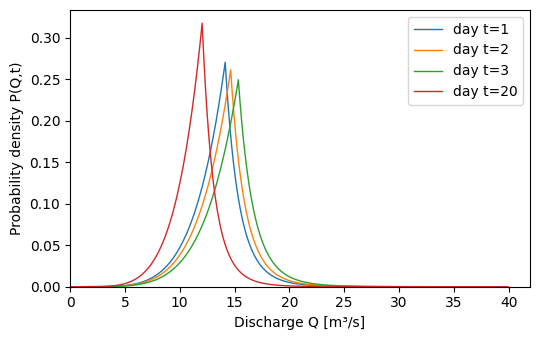

In [70]:
# Create a figure and axes with a reduced figure size
fig, ax1 = plt.subplots(figsize=(5.5, 3.5))

plt.plot(Q_x[:800], P[:800,1], label='day t=1', linewidth=1)
plt.plot(Q_x[:800], P[:800,2], label='day t=2', linewidth=1)
plt.plot(Q_x[:800], P[:800,3], label='day t=3', linewidth=1)
plt.plot(Q_x[:800], P[:800,20], label='day t=20', linewidth=1)
plt.xlabel('Discharge Q [m³/s]')
plt.ylabel('Probability density P(Q,t)')

# Define axis limits
plt.xlim(0)
plt.ylim(bottom=0)

plt.legend()
#plt.grid()

# Use tight_layout to avoid overlaps
plt.tight_layout()

# Save the plot as a .jpeg file
plt.savefig("FPE1.jpeg", format='jpeg', dpi=500)

# Download the file
#files.download("FPE1.jpeg")

plt.show()


Mode Method

In [71]:
def int_conf(x, y, confidence_level):

    # Sort x and y based on (y values in descending order)
    sorted_indices = np.argsort(y)[::-1]
    x_sorted = x[sorted_indices]
    y_sorted = y[sorted_indices]

    # cumulative areas following y_sorted
    cumulative_density = np.zeros(len(x))
    for i in range(2, len(x)+1):  # Commence à 2 pour avoir au moins deux points
        cumulative_density[i-1] = simps(y_sorted[:i], x[:i])

    # Normalize the CDF to ensure it ranges from 0 to 1
    cumulative_density /= cumulative_density[-1]

    # Find the interval that contains the desired credible level
    within_interval = cumulative_density <= confidence_level       #booleen: True or False. So, within_interval only contains True
    x_interval = x_sorted[within_interval]

    lower_bound = np.min(x_interval)
    upper_bound = np.max(x_interval)

    return lower_bound, upper_bound


<ipython-input-72-e89d0260c531>:10: DeprecationWarning:

'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0

<ipython-input-71-836287453165>:11: DeprecationWarning:

'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0



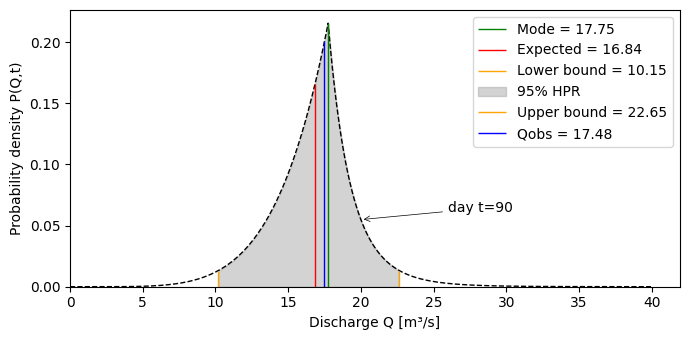

In [72]:
t = 90

# True discharge
tdischarge = discharge[t]
# Index of the maximum value of P(Q,t)
max_indices = np.argmax(P[:, t], axis=0)
# Corresponding Q values for each index
modes = Q_x[max_indices]
# Expectation
expect = simps(Q_x * P[:, t], Q_x)

# Compute lower and upper bounds of the 95% confidence interval
inff, supp = int_conf(Q_x, P[:, t], 0.95)

# Create a figure and axes with a reduced figure size
fig, ax1 = plt.subplots(figsize=(7, 3.5))

# Density plot
plt.plot(Q_x[:800], P[:800, t], linewidth=1, color='black', linestyle='--')
plt.xlabel('Discharge Q [m³/s]')
plt.ylabel('Probability density P(Q,t)')

# Annotation
plt.annotate('day t=90', xy=(Q_x[400], P[400, t]), xytext=(Q_x[400] + 6, P[400, t] + 0.006),
             arrowprops=dict(facecolor='black', arrowstyle='->', lw=0.5))

# Function to find the height of the curve at a given point
def find_height(x_val, Q_x, P_col):
    idx = (np.abs(Q_x - x_val)).argmin()  # Find the index of the closest point
    return P_col[idx]

# Find the heights of the curve at the specified points
modes_height = find_height(modes, Q_x, P[:, t])
expect_height = find_height(expect, Q_x, P[:, t])
inff_height = find_height(inff, Q_x, P[:, t])
supp_height = find_height(supp, Q_x, P[:, t])
tdischarge_height = find_height(tdischarge, Q_x, P[:, t])

# Add vertical lines that stop at the curve
plt.vlines(x=modes, ymin=0, ymax=modes_height, color='green', linestyle='-', linewidth=1, label=f'Mode = {modes:.2f}')
plt.vlines(x=expect, ymin=0, ymax=expect_height, color='red', linestyle='-', linewidth=1, label=f'Expected = {expect:.2f}')
plt.vlines(x=inff, ymin=0, ymax=inff_height, color='orange', linestyle='-', linewidth=1, label=f'Lower bound = {inff:.2f}')
plt.fill_between(Q_x, P[:, t], where=((Q_x < supp) & (Q_x > inff)), color=(169/255, 169/255, 169/255, 0.5), alpha=0.5, label='95% HPR')
plt.vlines(x=supp, ymin=0, ymax=supp_height, color='orange', linestyle='-', linewidth=1, label=f'Upper bound = {supp:.2f}')
plt.vlines(x=tdischarge, ymin=0, ymax=tdischarge_height, color='blue', linestyle='-', linewidth=1, label=f'Qobs = {tdischarge:.2f}')

# Set axis limits
plt.xlim(0)
plt.ylim(bottom=0)

# Add legend
plt.legend()

# Use tight_layout to avoid overlaps
plt.tight_layout()

# Save the plot as a .jpeg file
plt.savefig("FPE1_CI.jpeg", format='jpeg', dpi=500)

# Show the plot
plt.show()


In [73]:
# Index of the maximum value of P(Q,t) for each column
max_indices = np.argmax(P, axis=0)
# Corresponding Q values for each index
MODES = Q_x[max_indices]

# Expectation
expectations = np.array([simps(Q_x * P[:, k], Q_x) for k in range(P.shape[1])])

<ipython-input-73-55bf9fee125f>:7: DeprecationWarning:

'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0



In [74]:
num_timesteps = P.shape[1]
# Arrays to store inff and supp for each t
inff_values = np.zeros(num_timesteps)
supp_values = np.zeros(num_timesteps)
# Calculate inff and supp for each t
for t in range(1, num_timesteps):
    inff, supp = int_conf(Q_x, P[:, t], 0.9)
    inff_values[t] = inff
    supp_values[t] = supp


<ipython-input-71-836287453165>:11: DeprecationWarning:

'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0



In [75]:
import plotly.graph_objects as go

# Create a date range from '01-02-2018' to '12-31-2019'
time1 = np.datetime64('2018-01-02')
time2 = np.datetime64('2019-12-31')
time = np.arange(time1, time2 + np.timedelta64(1, 'D'), dtype='datetime64[D]')


# Trace for the upper bound without a name in the legend
upper_trace = go.Scatter(
    x=time,
    y=supp_values[1:],
    mode='lines',
    line=dict(color='rgba(169, 169, 169, 0.7)', width=2),
    showlegend=False  # Does not display this trace in the legend
)

# Trace for the lower bound with a name in the legend
lower_trace = go.Scatter(
    x=time,
    y=inff_values[1:],
    mode='lines',
    line=dict(color='rgba(169, 169, 169, 0.7)', width=2),
    fill='tonexty',
    fillcolor='rgba(169, 169, 169, 0.7)',  # Uncertainty zone in gray
    name='90% HPR'  # Name for the legend
)

# Trace for the expected values
mode_trace = go.Scatter(
    x=time,
    y=expectations[1:],
    mode='lines',
    line=dict(color='red', width=2),
    name = 'Expected'
)

# Trace for the observed values
real_trace = go.Scatter(
    x=time,
    y=discharge[1:],
    mode='lines',
    line=dict(color='blue', width=2),
    name='Observed'
)

# Add traces to the figure
data = [upper_trace, lower_trace, mode_trace, real_trace]
fig = go.Figure(data=data)

# Update the title with LaTeX text
fig.update_layout(
    title=r'90% High-Probability Region (HPR) with FPE',
    xaxis=dict(
        title='Time t',
        title_font=dict(size=25, color='black'),  # Darker and larger text
        tickfont=dict(size=18, color='black')    # Larger and darker labels
    ),
    yaxis=dict(
        title='Discharge Q [m³/s]',
        title_font=dict(size=22, color='black'), # Darker and larger text
        tickfont=dict(size=18, color='black')   # Larger and darker labels
    ),
    legend=dict(
        title='Legend',
        title_font=dict(size=20, color='black'), # Dark text
        font=dict(size=18, color='black')       # More readable legend
    ),
    template='plotly_white',
    width=820,  # Reduced width
    height=400   # Reduced height
)

# Save the figure as a JPEG image
fig.write_image("FPE_HPR_val_90.jpeg",  scale=22)

#Download
#files.download("FPE_HPR_val_90.jpeg")

# If you need to display the figure in a Jupyter notebook or similar environment
fig.show()


Performance Evaluation

In [76]:
#NSE, RMSE, R2
def nash_sutcliffe_efficiency(observed, simulated):
    obs_mean = np.mean(observed)
    numerator = np.sum((observed - simulated) ** 2)
    denominator = np.sum((observed - obs_mean) ** 2)

    nse = 1 - (numerator / denominator)
    return nse

def calculate_rmse(observed, predicted):

    rmse = np.sqrt(np.mean((observed - predicted)**2))
    return rmse

def calculate_r2(observed, predicted):

    mean_observed = np.mean(observed)
    mean_predicted = np.mean(predicted)

    numerator = np.sum((observed - mean_observed) * (predicted - mean_predicted))
    denominator = np.sqrt(np.sum((observed - mean_observed)**2)) * np.sqrt(np.sum((predicted - mean_predicted)**2))

    r2 = (numerator / denominator)**2
    return r2


In [77]:
#mode performance
nse_value = nash_sutcliffe_efficiency(discharge[1:], MODES[1:])
rmse_value = calculate_rmse(discharge[1:], MODES[1:])
r2_value = calculate_r2(discharge[1:], MODES[1:])
print("Nash-Sutcliffe Efficiency (NSE):", nse_value)
print("(RMSE):", rmse_value)
print("(R2):", r2_value)

Nash-Sutcliffe Efficiency (NSE): 0.9120941046706247
(RMSE): 11.6723513596867
(R2): 0.914002728520351


In [78]:
#expectation performance
nse_value = nash_sutcliffe_efficiency(discharge[1:], expectations[1:])
rmse_value = calculate_rmse(discharge[1:], expectations[1:])
print(nse_value)
print(rmse_value)

0.9230163113989466
10.923170418731997


In [79]:
observed = discharge[1:]
lower_bound = inff_values[1:]
upper_bound = supp_values[1:]

# Calculation of "hits" and "misses" for the Hit Rate (HR)
hits = np.sum((observed >= lower_bound) & (observed <= upper_bound))
misses = len(observed) - hits
hit_rate = (hits / (hits + misses)) * 100  # HR formula in percentage

# Calculation of the Mean Prediction Interval Width (MPIW)
mpiw = np.mean(upper_bound - lower_bound)

print(f"Hit Rate (HR) in %: {hit_rate:}")
print(f"Mean Prediction Interval Width (MPIW): {mpiw}")


Hit Rate (HR) in %: 91.35802469135803
Mean Prediction Interval Width (MPIW): 25.125651577503433


Quantile Method

In [80]:
def ci_percentiles(x, y, confidence_level):

    # Compute the CDF using Simpson's rule
    cdf = np.array([simps(y[:i+1], x[:i+1]) for i in range(len(x))])

    # Find the percentiles corresponding to the confidence level
    lower_percentile = (1 - confidence_level) / 2
    upper_percentile = 1 - lower_percentile

    # Interpolate to find the bounds
    lower_bound = np.interp(lower_percentile, cdf, x)
    upper_bound = np.interp(upper_percentile, cdf, x)

    return lower_bound, upper_bound


In [81]:
num_timesteps = P.shape[1]
# Arrays to store inff and supp for each t
inff_values = np.zeros(num_timesteps)
supp_values = np.zeros(num_timesteps)
# Calculate inff and supp for each t
for t in range(1, num_timesteps):
    inff, supp = ci_percentiles(Q_x, P[:, t], 0.9)
    inff_values[t] = inff
    supp_values[t] = supp



<ipython-input-80-f70f9beb4a67>:4: DeprecationWarning:

'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0



In [82]:
# Create a date range from '01-02-2018' to '12-31-2019'
time1 = np.datetime64('2018-01-02')
time2 = np.datetime64('2019-12-31')
time = np.arange(time1, time2 + np.timedelta64(1, 'D'), dtype='datetime64[D]')

# Trace for the upper bound without a name in the legend
upper_trace = go.Scatter(
    x=time,
    y=supp_values[1:],
    mode='lines',
    line=dict(color='rgba(169, 169, 169, 0.7)', width=2),
    showlegend=False  # Does not display this trace in the legend
)

# Trace for the lower bound with a name in the legend
lower_trace = go.Scatter(
    x=time,
    y=inff_values[1:],
    mode='lines',
    line=dict(color='rgba(169, 169, 169, 0.7)', width=2),
    fill='tonexty',
    fillcolor='rgba(169, 169, 169, 0.7)',  # Uncertainty zone in gray
    name='90% QI'  # Name for the legend
)

# Trace for the expected value
mode_trace = go.Scatter(
    x=time,
    y=expectations[1:],
    mode='lines',
    line=dict(color='red', width=2),
    name='Expected'
)

# Trace for observed values
real_trace = go.Scatter(
    x=time,
    y=discharge[1:],
    mode='lines',
    line=dict(color='blue', width=2),
    name='Observed'
)

# Add traces to the figure
data = [upper_trace, lower_trace, mode_trace, real_trace]
fig = go.Figure(data=data)

# Update the title with LaTeX text
fig.update_layout(
    title=r'90% Quantile Interval (QI) with FPE',
    xaxis=dict(
        title='Time t',
        title_font=dict(size=25, color='black'),  # Darker and larger text
        tickfont=dict(size=18, color='black')    # Larger, darker labels
    ),
    yaxis=dict(
        title='Discharge Q [m³/s]',
        title_font=dict(size=22, color='black'),  # Darker and larger text
        tickfont=dict(size=18, color='black')    # Larger, darker labels
    ),
    legend=dict(
        title='Legend',
        title_font=dict(size=20, color='black'),  # Dark text
        font=dict(size=18, color='black')        # More readable legend
    ),
    template='plotly_white',
    width=800,  # Reduced width
    height=400  # Reduced height
)

# Save the figure as a JPEG image
fig.write_image("FPE_QI_val_90.jpeg", scale=22)

# Download (uncomment if needed in your environment)
# files.download("FPE_QI_val_90.jpeg")

# If you need to display the figure in a Jupyter notebook or similar environment
fig.show()


In [83]:
observed = discharge[1:]
lower_bound = inff_values[1:]
upper_bound = supp_values[1:]

# Calculate the "hits" and "misses" for the Hit Rate (HR)
hits = np.sum((observed >= lower_bound) & (observed <= upper_bound))
misses = len(observed) - hits
hit_rate = (hits / (hits + misses)) * 100  # HR formula in percentage

# Calculate the Mean Prediction Interval Width (MPIW)
mpiw = np.mean(upper_bound - lower_bound)

print(f"Hit Rate (HR) in %: {hit_rate:}")
print(f"Mean Prediction Interval Width (MPIW): {mpiw}")


Hit Rate (HR) in %: 92.04389574759945
Mean Prediction Interval Width (MPIW): 25.399026722452355
